In [ ]:
   import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
import os
import keras
import random
import shutil
from matplotlib.image import imread
from pathlib import Path
import shutil
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization,Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

from google.colab import files
files.upload()

Saving kaggle-4.json to kaggle-4.json


{'kaggle-4.json': b'{"username":"testkaggle123123","key":"3012faec5be70d0a7299c41cd95e6ed5"}'}

In [ ]:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:

!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
 94% 97.0M/103M [00:00<00:00, 187MB/s]
100% 103M/103M [00:00<00:00, 157MB/s] 


In [ ]:

with zipfile.ZipFile("car-vs-bike-classification-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

In [ ]:

data_dir = "./data/Car-Bike-Dataset"

In [ ]:

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

Found 3200 images belonging to 2 classes.


In [ ]:

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 800 images belonging to 2 classes.


In [ ]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu', ),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


In [ ]:

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 470ms/step - accuracy: 0.6117 - loss: 10.0379 - val_accuracy: 0.5000 - val_loss: 6.0987 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 431ms/step - accuracy: 0.7296 - loss: 3.6402 - val_accuracy: 0.5000 - val_loss: 7.1204 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.7620 - loss: 1.8029 - val_accuracy: 0.5375 - val_loss: 1.6940 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 431ms/step - accuracy: 0.8039 - loss: 1.0337 - val_accuracy: 0.5425 - val_loss: 1.5134 - learning_rate: 0.0010
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.8072 - loss: 0.6521 - val_accuracy: 0.6413 - val_loss: 0.8933 - learning_rate: 0.0010
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - accuracy: 0.8221 - loss: 0.6826 - val_accuracy: 0.8000 - val_loss: 0.4618 - learning_rate: 0.0010
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.

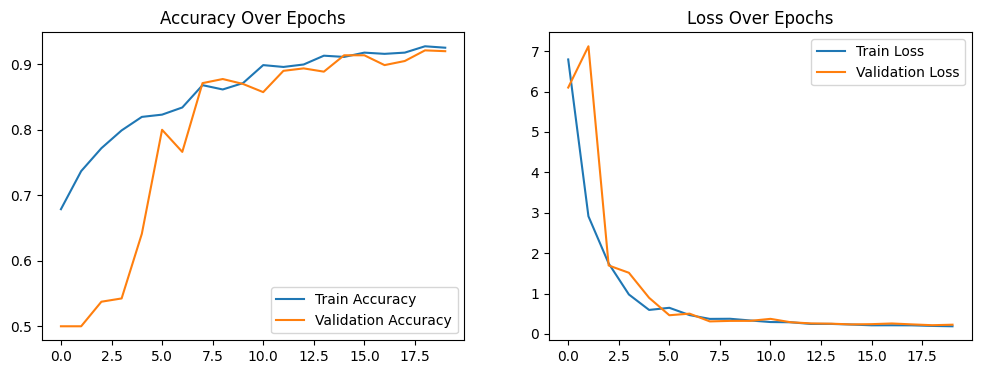

In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

model_path = 'model-jazin-car-vs-bike.tflite'
with open(model_path, 'wb') as f:
    f.write(tflite_model)

size_in_bytes = os.path.getsize(model_path)
size_in_mb = size_in_bytes / 1024 / 1024

print(f"Quantized Model Size: {size_in_mb:.2f} MB")

Saved artifact at '/tmp/tmplkusvmq6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138173626668560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626666832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626665680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626663760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626667216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626663568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626667024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626663184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626663376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138173626665488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13817362666587

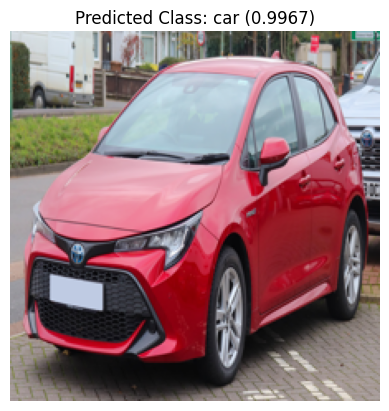

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

interpreter = tf.lite.Interpreter(model_path="/content/model-jazin-car-vs-bike.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = '/content/2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg'
img = Image.open(image_path)

input_shape = input_details[0]['shape']
target_height, target_width = input_shape[1], input_shape[2]
expected_channels = input_shape[3]

img = img.resize((target_width, target_height))

img_array = np.array(img).astype(np.float32) / 255.0

if expected_channels == 1:
    img_array = np.mean(img_array, axis=-1, keepdims=True)

img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

predictions = interpreter.get_tensor(output_details[0]['index'])

probability = predictions[0][0]

class_labels = ['bike', 'car']

predicted_class = 1 if probability >= 0.5 else 0
predicted_label = class_labels[predicted_class]
plt.title(f"Predicted Class: {predicted_label} ({probability:.4f})")
plt.imshow(img)
plt.axis('off')
plt.show()